In [1]:
!pip install torchinfo

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [31]:
batch_size = 32
learning_rate = 5e-6
num_epochs = 50
weight_decay = 1e-6

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [7]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [8]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [9]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [10]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [11]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [13]:
class LeViTDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LeViTDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [14]:
model = LeViTDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, eta_min=1e-6)

LeViTDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [15]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-01-21 23:40:05--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  16.6MB/s    in 45s     

2025-01-21 23:40:51 (17.1 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [16]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LeViTDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [18]:
val_dir = 'val/CRC-VAL-HE-7K'

transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_data = datasets.ImageFolder(root=val_dir, transform=transform)

In [19]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, eta_min=1e-6)

In [21]:
val_losses = []
val_accuracies = []

In [33]:
print(val_losses)

[0.7365632433844975, 0.5719279003178055]


In [36]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [22]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [23]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [24]:
model_path = "HoViT_NCT_batch_32_scheduler_cosineAnnealingWR_50.pth" # Path to the saved weights
model.load_state_dict(torch.load(model_path, map_location=device))
print("Model weights loaded successfully!")

Model weights loaded successfully!


<ipython-input-24-08d9513a0d7f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [25]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 225
Average Time: 5.65 ms
Standard Deviation: 3.88 ms
Maximum Time: 63.54 ms
Minimum Time: 5.11 ms


In [26]:
evaluate(model, test_loader, criterion, device)

Validation: 100%|██████████| 225/225 [00:09<00:00, 22.66it/s]

Validation Loss: 0.7366, Validation Accuracy: 87.44%


In [27]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.07%     392.473us        20.02%       3.802ms     158.415us       0.000us         0.00%       2.536ms     105.661us            24  
                                           aten::linear         0.92%     175.592us        14.65%       2.782ms     154.569us       0.000us         0.00%       1.827ms     101.520us            18  
         

In [28]:
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs2 = model(inputs.flip(2))
            outputs3 = model(inputs.flip(3))
            outputs23 = model(inputs.flip(2).flip(3))
            outputs = outputs.data + outputs2.data + outputs3 + outputs23.data
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels) / 4

            running_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_labels_binarized = label_binarize(all_labels, classes=class_labels)
    fpr, tpr, _ = roc_curve(all_labels_binarized.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

Validation: 100%|██████████| 225/225 [00:14<00:00, 15.57it/s]


Validation Loss: 0.5719, Validation Accuracy: 89.62%
Overall - F1: 0.8646, Recall: 0.8713, Precision: 0.8797
Per-Class Metrics:
Class 0 - F1: 0.9193, Recall: 0.8894, Precision: 0.9512
Class 1 - F1: 0.9843, Recall: 1.0000, Precision: 0.9691
Class 2 - F1: 0.8298, Recall: 0.9705, Precision: 0.7247
Class 3 - F1: 0.9728, Recall: 0.9606, Precision: 0.9854
Class 4 - F1: 0.9604, Recall: 0.9382, Precision: 0.9838
Class 5 - F1: 0.7478, Recall: 0.8615, Precision: 0.6606
Class 6 - F1: 0.8703, Recall: 0.8151, Precision: 0.9335
Class 7 - F1: 0.5767, Recall: 0.4418, Precision: 0.8304
Class 8 - F1: 0.9196, Recall: 0.9643, Precision: 0.8788
Balanced Accuracy: 0.8713


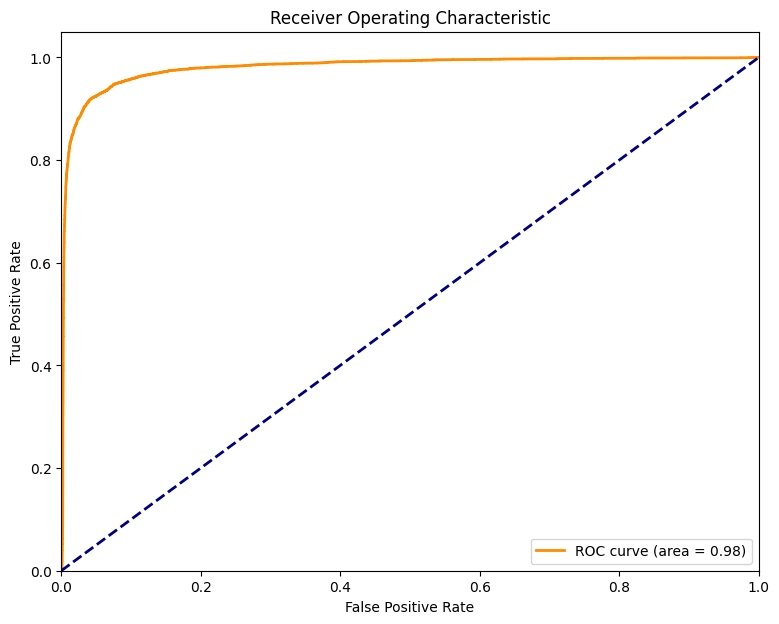

In [29]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device)

<Figure size 2000x1200 with 0 Axes>

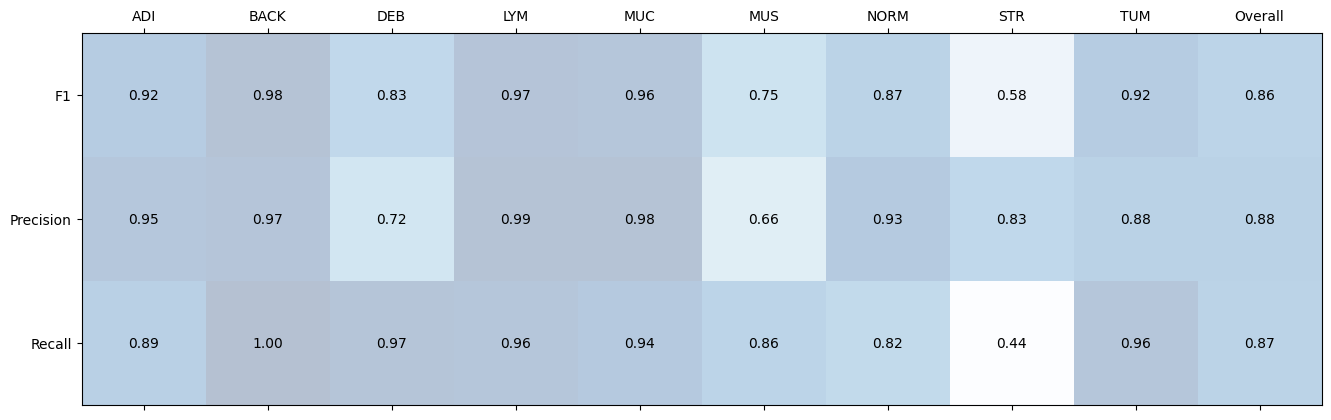

In [30]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

# 100 Epochs train result

In [32]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

train_dir = './train/NCT-CRC-HE-100K'

--2025-01-21 23:50:30--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-21 23:50:31--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  16.6MB/s    in 11m 18s 

2025-01-22 00:01:49 (16.4 MB/s) - ‘NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]



In [39]:
train_set = datasets.ImageFolder(root=train_dir, transform=transform)

In [40]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


data_paths, labels = zip(*train_set.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(train_set, train_idx)
val_data = Subset(train_set, val_idx)
testt_data = Subset(train_set, test_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
testt_loader = DataLoader(testt_data, batch_size=batch_size, shuffle=False)

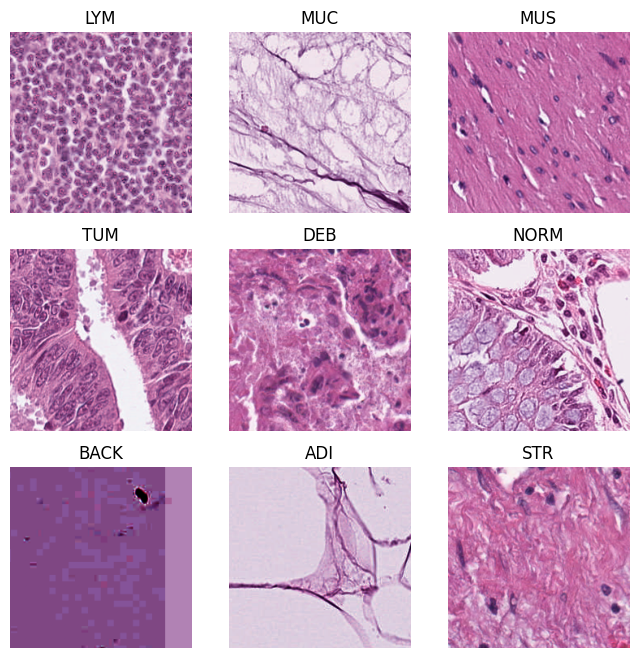

In [41]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(train_set.classes):
            break
    if len(class_examples) == len(train_set.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(train_set.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(train_set.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [43]:
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

In [44]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    validation_losses.append(epoch_loss)
    validation_accuracies.append(accuracy)

In [45]:
for e in range(num_epochs):
    print(f"\nEpoch {e+51}/{100}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 51/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.42it/s]


Train Loss: 0.0006, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]


Validation Loss: 0.0305, Validation Accuracy: 99.21%

Epoch 52/100


Training: 100%|██████████| 2188/2188 [02:11<00:00, 16.59it/s]


Train Loss: 0.0008, Train Accuracy: 99.98%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


Validation Loss: 0.0293, Validation Accuracy: 99.24%

Epoch 53/100


Training: 100%|██████████| 2188/2188 [02:12<00:00, 16.58it/s]


Train Loss: 0.0005, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]


Validation Loss: 0.0329, Validation Accuracy: 99.10%

Epoch 54/100


Training: 100%|██████████| 2188/2188 [02:12<00:00, 16.46it/s]


Train Loss: 0.0005, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]


Validation Loss: 0.0282, Validation Accuracy: 99.25%

Epoch 55/100


Training: 100%|██████████| 2188/2188 [02:11<00:00, 16.58it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]


Validation Loss: 0.0264, Validation Accuracy: 99.27%

Epoch 56/100


Training: 100%|██████████| 2188/2188 [02:12<00:00, 16.50it/s]


Train Loss: 0.0004, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s]


Validation Loss: 0.0273, Validation Accuracy: 99.25%

Epoch 57/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.42it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


Validation Loss: 0.0284, Validation Accuracy: 99.26%

Epoch 58/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.38it/s]


Train Loss: 0.0004, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]


Validation Loss: 0.0298, Validation Accuracy: 99.25%

Epoch 59/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.38it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]


Validation Loss: 0.0295, Validation Accuracy: 99.25%

Epoch 60/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.35it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]


Validation Loss: 0.0269, Validation Accuracy: 99.27%

Epoch 61/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.36it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]


Validation Loss: 0.0284, Validation Accuracy: 99.30%

Epoch 62/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.34it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]


Validation Loss: 0.0312, Validation Accuracy: 99.23%

Epoch 63/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.25it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


Validation Loss: 0.0281, Validation Accuracy: 99.30%

Epoch 64/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.29it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]


Validation Loss: 0.0283, Validation Accuracy: 99.26%

Epoch 65/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.34it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]


Validation Loss: 0.0285, Validation Accuracy: 99.31%

Epoch 66/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.32it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]


Validation Loss: 0.0288, Validation Accuracy: 99.28%

Epoch 67/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.35it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Validation Loss: 0.0314, Validation Accuracy: 99.25%

Epoch 68/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.38it/s]


Train Loss: 0.0003, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]


Validation Loss: 0.0292, Validation Accuracy: 99.29%

Epoch 69/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.39it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Validation Loss: 0.0302, Validation Accuracy: 99.27%

Epoch 70/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.35it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]


Validation Loss: 0.0321, Validation Accuracy: 99.20%

Epoch 71/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.35it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Validation Loss: 0.0307, Validation Accuracy: 99.25%

Epoch 72/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.33it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Validation Loss: 0.0308, Validation Accuracy: 99.27%

Epoch 73/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.33it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]


Validation Loss: 0.0311, Validation Accuracy: 99.25%

Epoch 74/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.38it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]


Validation Loss: 0.0320, Validation Accuracy: 99.26%

Epoch 75/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.40it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]


Validation Loss: 0.0304, Validation Accuracy: 99.26%

Epoch 76/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.38it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]


Validation Loss: 0.0310, Validation Accuracy: 99.29%

Epoch 77/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.36it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]


Validation Loss: 0.0318, Validation Accuracy: 99.25%

Epoch 78/100


Training: 100%|██████████| 2188/2188 [02:15<00:00, 16.16it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


Validation Loss: 0.0340, Validation Accuracy: 99.23%

Epoch 79/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.29it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]


Validation Loss: 0.0299, Validation Accuracy: 99.33%

Epoch 80/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.24it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


Validation Loss: 0.0301, Validation Accuracy: 99.31%

Epoch 81/100


Training: 100%|██████████| 2188/2188 [02:15<00:00, 16.20it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


Validation Loss: 0.0294, Validation Accuracy: 99.28%

Epoch 82/100


Training: 100%|██████████| 2188/2188 [02:15<00:00, 16.20it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


Validation Loss: 0.0311, Validation Accuracy: 99.28%

Epoch 83/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.25it/s]


Train Loss: 0.0001, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]


Validation Loss: 0.0318, Validation Accuracy: 99.31%

Epoch 84/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.23it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]


Validation Loss: 0.0307, Validation Accuracy: 99.29%

Epoch 85/100


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.06it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Validation Loss: 0.0318, Validation Accuracy: 99.33%

Epoch 86/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.45it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]


Validation Loss: 0.0300, Validation Accuracy: 99.31%

Epoch 87/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.44it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]


Validation Loss: 0.0300, Validation Accuracy: 99.33%

Epoch 88/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.28it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]


Validation Loss: 0.0303, Validation Accuracy: 99.35%

Epoch 89/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.32it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]


Validation Loss: 0.0327, Validation Accuracy: 99.25%

Epoch 90/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.35it/s]


Train Loss: 0.0002, Train Accuracy: 99.99%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Validation Loss: 0.0312, Validation Accuracy: 99.30%

Epoch 91/100


Training: 100%|██████████| 2188/2188 [02:13<00:00, 16.36it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]


Validation Loss: 0.0320, Validation Accuracy: 99.31%

Epoch 92/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.31it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]


Validation Loss: 0.0311, Validation Accuracy: 99.33%

Epoch 93/100


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.05it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Validation Loss: 0.0336, Validation Accuracy: 99.31%

Epoch 94/100


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.07it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]


Validation Loss: 0.0302, Validation Accuracy: 99.32%

Epoch 95/100


Training: 100%|██████████| 2188/2188 [02:16<00:00, 15.99it/s]


Train Loss: 0.0002, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]


Validation Loss: 0.0304, Validation Accuracy: 99.33%

Epoch 96/100


Training: 100%|██████████| 2188/2188 [02:16<00:00, 15.97it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]


Validation Loss: 0.0306, Validation Accuracy: 99.36%

Epoch 97/100


Training: 100%|██████████| 2188/2188 [02:15<00:00, 16.19it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]


Validation Loss: 0.0317, Validation Accuracy: 99.32%

Epoch 98/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.26it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Validation Loss: 0.0336, Validation Accuracy: 99.30%

Epoch 99/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.29it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]


Validation Loss: 0.0308, Validation Accuracy: 99.35%

Epoch 100/100


Training: 100%|██████████| 2188/2188 [02:14<00:00, 16.31it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]

Validation Loss: 0.0322, Validation Accuracy: 99.31%


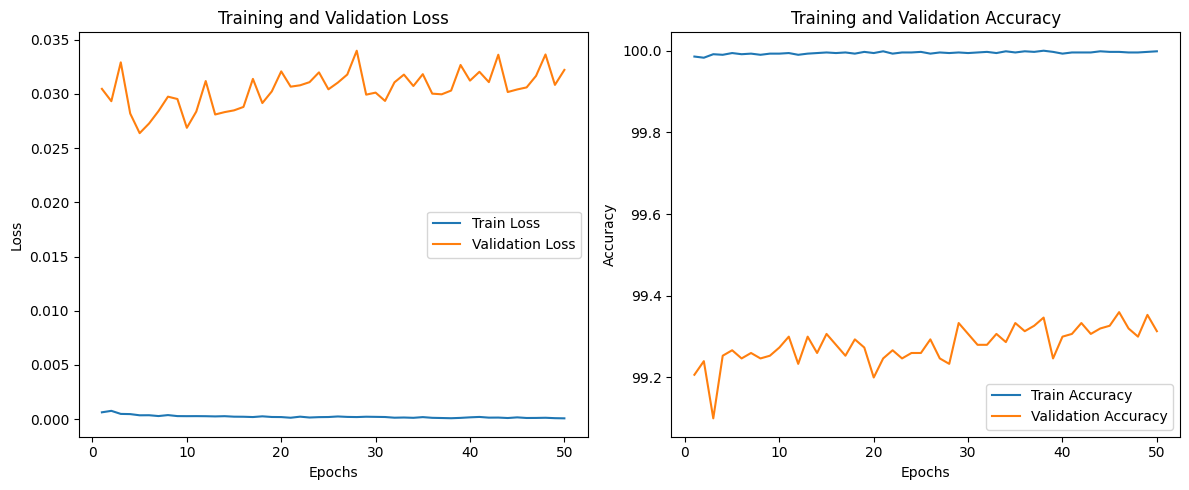

In [46]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, validation_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
evaluate(model, testt_loader, criterion, device)

Validation: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]

Validation Loss: 0.0323, Validation Accuracy: 99.35%


In [51]:
model_path = "HoViT_NCT_batch_32_cosineAnnealing_100.pth"  # Choose a descriptive filename
torch.save(model.state_dict(), model_path)
print(f"Model checkpoint saved to {model_path}")

Model checkpoint saved to HoViT_NCT_batch_32_cosineAnnealing_100.pth


In [58]:
times = measure_inference_time(model, test_loader, device) # 7K test set

Inference Time Measurement Results:
Total Inferences: 225
Average Time: 6.74 ms
Standard Deviation: 0.27 ms
Maximum Time: 8.04 ms
Minimum Time: 6.32 ms


In [55]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.32%     218.778us        23.58%       2.228ms      92.830us       0.000us         0.00%       2.527ms     105.292us            24  
                                           aten::linear         1.28%     121.101us        16.22%       1.533ms      85.159us       0.000us         0.00%       1.823ms     101.257us            18  
         

Validation: 100%|██████████| 225/225 [00:14<00:00, 15.35it/s]


Validation Loss: 0.5863, Validation Accuracy: 92.48%
Overall - F1: 0.8895, Recall: 0.8958, Precision: 0.8974
Per-Class Metrics:
Class 0 - F1: 0.9776, Recall: 0.9806, Precision: 0.9747
Class 1 - F1: 0.9630, Recall: 1.0000, Precision: 0.9287
Class 2 - F1: 0.8175, Recall: 0.9646, Precision: 0.7093
Class 3 - F1: 0.9617, Recall: 0.9716, Precision: 0.9521
Class 4 - F1: 0.9675, Recall: 0.9498, Precision: 0.9860
Class 5 - F1: 0.8143, Recall: 0.8260, Precision: 0.8030
Class 6 - F1: 0.9335, Recall: 0.9285, Precision: 0.9386
Class 7 - F1: 0.6170, Recall: 0.4917, Precision: 0.8280
Class 8 - F1: 0.9528, Recall: 0.9497, Precision: 0.9559
Balanced Accuracy: 0.8958


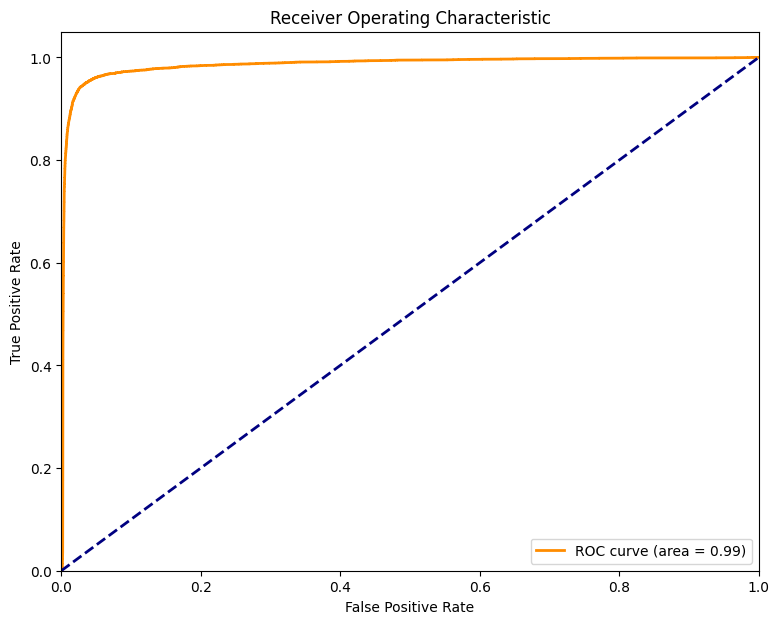

In [56]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device)

<Figure size 2000x1200 with 0 Axes>

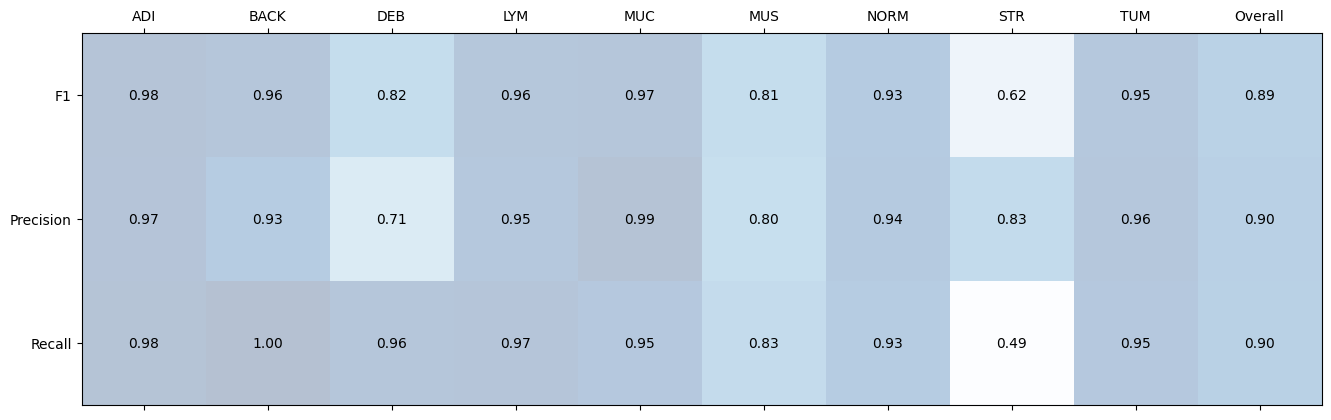

In [59]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )